In [ ]:
# Indicar si se montará el drive para colab
drive = True

In [ ]:
if drive:
  from google.colab import drive
  drive.mount('/content/drive/')
  # especificar el path al que se accederá en drive
  path = '/content/drive/Shareddrives/ML/Taller_3'
else:
  # especificar path a los datasets
  path = ''

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
# Indicar si el notebook se ejecutará en modo training o testing
training = True

# Import modules

In [ ]:
!pip install ReliefF

In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Import Data

In [ ]:
if training:
  # abundance_data = pd.read_csv(f'{path}/biomedata_train_abundance.csv')
  marker_data = pd.read_csv(f'{path}/biomedata_train_marker.csv')
  print("Loading training Datasets")
else:
  # abundance_data = pd.read_csv(f'{path}/biomedata_test_abundance.csv')
  marker_data = pd.read_csv(f'{path}/biomedata_test_marker.csv')
  print("Loading testing Datasets")

marker_data = marker_data.rename(columns={'Unnamed: 0': 'Id'})

Loading training Datasets


In [ ]:
if training:
  # y_abundance = abundance_data[['Obesity', 'Cirrhosis', 'Diabetes']]
  y_marker = marker_data[['Obesity', 'Cirrhosis', 'Diabetes']]
  # abundance_data = abundance_data.drop(columns=['Obesity', 'Cirrhosis', 'Diabetes'])
  marker_data = marker_data.drop(columns=['Obesity', 'Cirrhosis', 'Diabetes'])

# Data Exploration

In [ ]:
marker_data.head(5)

,Id,code_study,country,gender,gi|103485498|ref|NC_008048.1|:c103928-103680,gi|104773257|ref|NC_008054.1|:116729-117526,gi|104773257|ref|NC_008054.1|:1737697-1738332,gi|104773257|ref|NC_008054.1|:266275-267207,gi|104773257|ref|NC_008054.1|:294312-294563,gi|104773257|ref|NC_008054.1|:444407-444904,gi|104773257|ref|NC_008054.1|:54492-55274,gi|104773257|ref|NC_008054.1|:621607-622221,gi|104773257|ref|NC_008054.1|:794401-794844,gi|104773257|ref|NC_008054.1|:817772-818014,gi|104773257|ref|NC_008054.1|:839090-839893,gi|104773257|ref|NC_008054.1|:c1060211-1059462,gi|104773257|ref|NC_008054.1|:c1071276-1070581,gi|104773257|ref|NC_008054.1|:c1156068-1154920,gi|104773257|ref|NC_008054.1|:c1169983-1168085,gi|104773257|ref|NC_008054.1|:c1327487-1326282,gi|104773257|ref|NC_008054.1|:c1364348-1363743,gi|104773257|ref|NC_008054.1|:c1365657-1365112,gi|104773257|ref|NC_008054.1|:c1753212-1752712,gi|104773257|ref|NC_008054.1|:c425086-424721,gi|104773257|ref|NC_008054.1|:c492752-492150,gi|104773257|ref|NC_008054.1|:c853536-852661,gi|104773257|ref|NC_008054.1|:c869798-868797,gi|104773257|ref|NC_008054.1|:c993834-993223,gi|107770669|ref|NM_001040789.1|,gi|107868482|ref|NM_001040955.1|,gi|110636427|ref|NC_008255.1|:1928766-1929113,gi|110636427|ref|NC_008255.1|:2007555-2008244,gi|110636427|ref|NC_008255.1|:2144911-2145189,gi|110636427|ref|NC_008255.1|:3074386-3076455,gi|110636427|ref|NC_008255.1|:4237317-4238054,gi|110636427|ref|NC_008255.1|:4323479-4324639,gi|110636427|ref|NC_008255.1|:c2184296-2183436,gi|110636427|ref|NC_008255.1|:c3586657-3586250,gi|110798562|ref|NC_008261.1|:121034-121474,gi|110798562|ref|NC_008261.1|:1410448-1410915,...,gi|85372828|ref|NC_007722.1|:3001224-3001502,gi|85372828|ref|NC_007722.1|:3001535-3002416,gi|85372828|ref|NC_007722.1|:3006368-3006781,gi|85372828|ref|NC_007722.1|:3017209-3018381,gi|85372828|ref|NC_007722.1|:3018378-3018854,gi|85372828|ref|NC_007722.1|:3018861-3020111,gi|85372828|ref|NC_007722.1|:3034108-3034953,gi|85372828|ref|NC_007722.1|:827855-828763,gi|85372828|ref|NC_007722.1|:840955-841395,gi|85372828|ref|NC_007722.1|:842620-842883,gi|85372828|ref|NC_007722.1|:c1678750-1678445,gi|85372828|ref|NC_007722.1|:c2962716-2962081,gi|85372828|ref|NC_007722.1|:c2990559-2990038,gi|85372828|ref|NC_007722.1|:c2995293-2994421,gi|85372828|ref|NC_007722.1|:c2996606-2995290,gi|85372828|ref|NC_007722.1|:c2997421-2996606,gi|85372828|ref|NC_007722.1|:c3001138-3000908,gi|85372828|ref|NC_007722.1|:c3004141-3002555,gi|85372828|ref|NC_007722.1|:c3010113-3007429,gi|85372828|ref|NC_007722.1|:c894924-893911,gi|85707569|ref|NZ_AAMW01000001.1|:666073-666492,gi|85707569|ref|NZ_AAMW01000001.1|:c1251042-1250533,gi|85713430|ref|NZ_AAMY01000001.1|:181620-182330,gi|86747127|ref|NC_007778.1|:c120924-120565,gi|87122966|ref|NZ_AANE01000039.1|:8596-9090,gi|88607955|ref|NC_007798.1|:118090-119082,gi|88657561|ref|NC_007799.1|:c987429-987058,gi|88797415|ref|NZ_AAOE01000002.1|:c235147-234506,gi|89890966|ref|NZ_AAPD01000004.1|:c130582-129296,gi|89892746|ref|NC_007907.1|:5171129-5171617,gi|89892746|ref|NC_007907.1|:c3938880-3937900,gi|90581188|ref|NZ_AAOJ01000014.1|:76701-76972,gi|91774356|ref|NC_007947.1|:c416906-416292,gi|92112136|ref|NC_007963.1|:485202-485741,gi|92115633|ref|NC_007964.1|:c3043219-3042695,gi|93004831|ref|NC_007969.1|:1110067-1110642,gi|93004831|ref|NC_007969.1|:1986617-1987513,gi|94502223|ref|NZ_AANL01000001.1|:c8848-8444,gi|94676460|ref|NC_007984.1|:c601098-600646,gi|94991497|ref|NC_008023.1|:148294-148941
0,0,Quin_gut_liver_cirrhosis,china,female,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,Quin_gut_liver_cirrhosis,china,male,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
columnas = [x for x in marker_data.columns if 'gi|' not in x]
columnas

['Id', 'code_study', 'country', 'gender']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff85bcf99d0>,
      dtype=object)

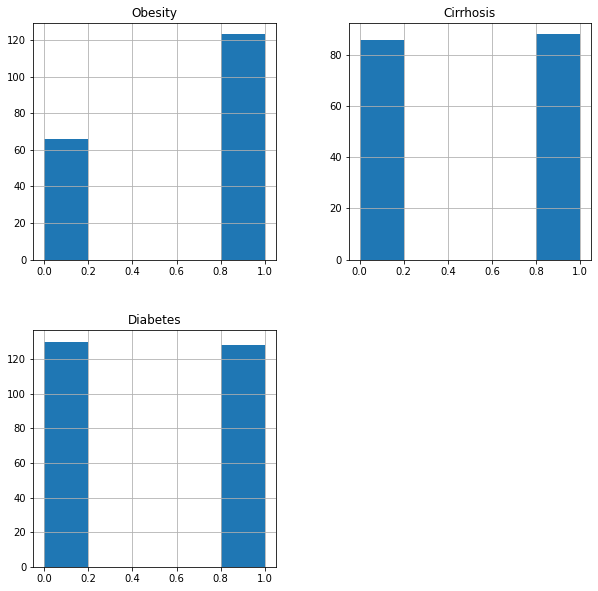

In [ ]:
y_marker.hist(figsize=(10,10), bins=5)

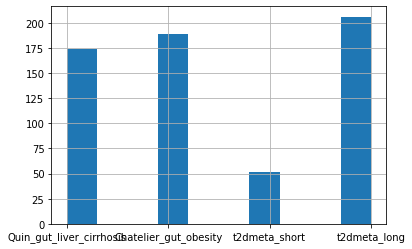

In [ ]:
marker_data['code_study'].hist()

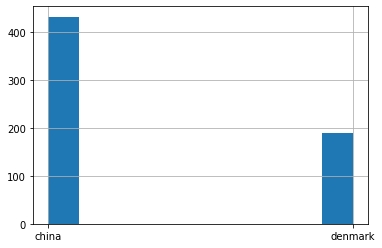

In [ ]:
marker_data['country'].hist()

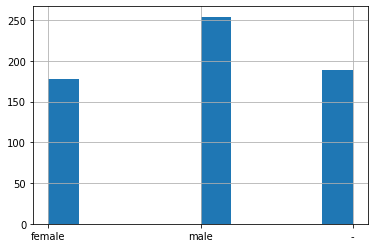

In [ ]:
marker_data['gender'].hist()

In [ ]:
marker_data['gender'].value_counts()

male      254
-         189
female    178
Name: gender, dtype: int64

In [ ]:
microbiota = [x for x in marker_data.columns if 'gi|' in x]

In [ ]:
n_rows = marker_data.shape[0]
n_rows

621

In [ ]:
nan_cols = []
for col in microbiota:
  if marker_data[col].isnull().sum(axis = 0) != 0:
    nan_cols.append(col)

In [ ]:
len(nan_cols)

75821

# Preprocessing

In [ ]:
marker_data.head(1)

,Id,code_study,country,gender,gi|103485498|ref|NC_008048.1|:c103928-103680,gi|104773257|ref|NC_008054.1|:116729-117526,gi|104773257|ref|NC_008054.1|:1737697-1738332,gi|104773257|ref|NC_008054.1|:266275-267207,gi|104773257|ref|NC_008054.1|:294312-294563,gi|104773257|ref|NC_008054.1|:444407-444904,gi|104773257|ref|NC_008054.1|:54492-55274,gi|104773257|ref|NC_008054.1|:621607-622221,gi|104773257|ref|NC_008054.1|:794401-794844,gi|104773257|ref|NC_008054.1|:817772-818014,gi|104773257|ref|NC_008054.1|:839090-839893,gi|104773257|ref|NC_008054.1|:c1060211-1059462,gi|104773257|ref|NC_008054.1|:c1071276-1070581,gi|104773257|ref|NC_008054.1|:c1156068-1154920,gi|104773257|ref|NC_008054.1|:c1169983-1168085,gi|104773257|ref|NC_008054.1|:c1327487-1326282,gi|104773257|ref|NC_008054.1|:c1364348-1363743,gi|104773257|ref|NC_008054.1|:c1365657-1365112,gi|104773257|ref|NC_008054.1|:c1753212-1752712,gi|104773257|ref|NC_008054.1|:c425086-424721,gi|104773257|ref|NC_008054.1|:c492752-492150,gi|104773257|ref|NC_008054.1|:c853536-852661,gi|104773257|ref|NC_008054.1|:c869798-868797,gi|104773257|ref|NC_008054.1|:c993834-993223,gi|107770669|ref|NM_001040789.1|,gi|107868482|ref|NM_001040955.1|,gi|110636427|ref|NC_008255.1|:1928766-1929113,gi|110636427|ref|NC_008255.1|:2007555-2008244,gi|110636427|ref|NC_008255.1|:2144911-2145189,gi|110636427|ref|NC_008255.1|:3074386-3076455,gi|110636427|ref|NC_008255.1|:4237317-4238054,gi|110636427|ref|NC_008255.1|:4323479-4324639,gi|110636427|ref|NC_008255.1|:c2184296-2183436,gi|110636427|ref|NC_008255.1|:c3586657-3586250,gi|110798562|ref|NC_008261.1|:121034-121474,gi|110798562|ref|NC_008261.1|:1410448-1410915,...,gi|85372828|ref|NC_007722.1|:3001224-3001502,gi|85372828|ref|NC_007722.1|:3001535-3002416,gi|85372828|ref|NC_007722.1|:3006368-3006781,gi|85372828|ref|NC_007722.1|:3017209-3018381,gi|85372828|ref|NC_007722.1|:3018378-3018854,gi|85372828|ref|NC_007722.1|:3018861-3020111,gi|85372828|ref|NC_007722.1|:3034108-3034953,gi|85372828|ref|NC_007722.1|:827855-828763,gi|85372828|ref|NC_007722.1|:840955-841395,gi|85372828|ref|NC_007722.1|:842620-842883,gi|85372828|ref|NC_007722.1|:c1678750-1678445,gi|85372828|ref|NC_007722.1|:c2962716-2962081,gi|85372828|ref|NC_007722.1|:c2990559-2990038,gi|85372828|ref|NC_007722.1|:c2995293-2994421,gi|85372828|ref|NC_007722.1|:c2996606-2995290,gi|85372828|ref|NC_007722.1|:c2997421-2996606,gi|85372828|ref|NC_007722.1|:c3001138-3000908,gi|85372828|ref|NC_007722.1|:c3004141-3002555,gi|85372828|ref|NC_007722.1|:c3010113-3007429,gi|85372828|ref|NC_007722.1|:c894924-893911,gi|85707569|ref|NZ_AAMW01000001.1|:666073-666492,gi|85707569|ref|NZ_AAMW01000001.1|:c1251042-1250533,gi|85713430|ref|NZ_AAMY01000001.1|:181620-182330,gi|86747127|ref|NC_007778.1|:c120924-120565,gi|87122966|ref|NZ_AANE01000039.1|:8596-9090,gi|88607955|ref|NC_007798.1|:118090-119082,gi|88657561|ref|NC_007799.1|:c987429-987058,gi|88797415|ref|NZ_AAOE01000002.1|:c235147-234506,gi|89890966|ref|NZ_AAPD01000004.1|:c130582-129296,gi|89892746|ref|NC_007907.1|:5171129-5171617,gi|89892746|ref|NC_007907.1|:c3938880-3937900,gi|90581188|ref|NZ_AAOJ01000014.1|:76701-76972,gi|91774356|ref|NC_007947.1|:c416906-416292,gi|92112136|ref|NC_007963.1|:485202-485741,gi|92115633|ref|NC_007964.1|:c3043219-3042695,gi|93004831|ref|NC_007969.1|:1110067-1110642,gi|93004831|ref|NC_007969.1|:1986617-1987513,gi|94502223|ref|NZ_AANL01000001.1|:c8848-8444,gi|94676460|ref|NC_007984.1|:c601098-600646,gi|94991497|ref|NC_008023.1|:148294-148941
0,0,Quin_gut_liver_cirrhosis,china,female,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,0.0,0,0,0,0,0,0,0,0,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Categorical variables

In [ ]:
cat_data = pd.get_dummies(marker_data[['code_study', 'country', 'gender']])
cat_data

,code_study_Chatelier_gut_obesity,code_study_Quin_gut_liver_cirrhosis,code_study_t2dmeta_long,code_study_t2dmeta_short,country_china,country_denmark,gender_-,gender_female,gender_male
0,0,1,0,0,1,0,0,1,0
1,0,1,0,0,1,0,0,0,1
2,0,1,0,0,1,0,0,0,1
3,0,1,0,0,1,0,0,1,0
4,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...
616,0,0,1,0,1,0,0,0,1
617,0,0,0,1,1,0,0,0,1
618,0,0,1,0,1,0,0,0,1
619,0,0,1,0,1,0,0,0,1


## Microbiota data

In [ ]:
data_test = marker_data

In [ ]:
data_test = data_test.drop(columns=nan_cols)

In [ ]:
all_columns = data_test.columns
normal_columns = [x for x in all_columns if 'gi|' not in x]

In [ ]:
microbiota = [x for x in all_columns if 'gi|' in x]

In [ ]:
data_test[microbiota].head(3)

,gi|104773257|ref|NC_008054.1|:116729-117526,gi|104773257|ref|NC_008054.1|:1737697-1738332,gi|104773257|ref|NC_008054.1|:266275-267207,gi|104773257|ref|NC_008054.1|:294312-294563,gi|104773257|ref|NC_008054.1|:444407-444904,gi|104773257|ref|NC_008054.1|:54492-55274,gi|104773257|ref|NC_008054.1|:621607-622221,gi|104773257|ref|NC_008054.1|:794401-794844,gi|104773257|ref|NC_008054.1|:817772-818014,gi|104773257|ref|NC_008054.1|:839090-839893,gi|104773257|ref|NC_008054.1|:c1060211-1059462,gi|104773257|ref|NC_008054.1|:c1071276-1070581,gi|104773257|ref|NC_008054.1|:c1156068-1154920,gi|104773257|ref|NC_008054.1|:c1169983-1168085,gi|104773257|ref|NC_008054.1|:c1327487-1326282,gi|104773257|ref|NC_008054.1|:c1364348-1363743,gi|104773257|ref|NC_008054.1|:c1365657-1365112,gi|104773257|ref|NC_008054.1|:c1753212-1752712,gi|104773257|ref|NC_008054.1|:c425086-424721,gi|104773257|ref|NC_008054.1|:c492752-492150,gi|104773257|ref|NC_008054.1|:c853536-852661,gi|104773257|ref|NC_008054.1|:c993834-993223,gi|110636427|ref|NC_008255.1|:1928766-1929113,gi|110636427|ref|NC_008255.1|:2007555-2008244,gi|110636427|ref|NC_008255.1|:2144911-2145189,gi|110636427|ref|NC_008255.1|:3074386-3076455,gi|110636427|ref|NC_008255.1|:4237317-4238054,gi|110636427|ref|NC_008255.1|:4323479-4324639,gi|110636427|ref|NC_008255.1|:c2184296-2183436,gi|110636427|ref|NC_008255.1|:c3586657-3586250,gi|110798562|ref|NC_008261.1|:121034-121474,gi|110798562|ref|NC_008261.1|:1410448-1410915,gi|110798562|ref|NC_008261.1|:1511973-1512524,gi|110798562|ref|NC_008261.1|:1840499-1841575,gi|110798562|ref|NC_008261.1|:20680-20913,gi|110798562|ref|NC_008261.1|:3090184-3090792,gi|110798562|ref|NC_008261.1|:381297-382679,gi|110798562|ref|NC_008261.1|:468822-469433,gi|110798562|ref|NC_008261.1|:598227-599498,gi|110798562|ref|NC_008261.1|:666517-667398,...,gi|84488831|ref|NC_007681.1|:c952785-952528,gi|84488831|ref|NC_007681.1|:c963941-963549,gi|84488831|ref|NC_007681.1|:c993719-992931,gi|85057280|ref|NC_007716.1|:c475337-474918,gi|85857845|ref|NC_007759.1|:2461251-2462021,gi|89892746|ref|NC_007907.1|:157563-158282,gi|89892746|ref|NC_007907.1|:c2157843-2156926,gi|90960990|ref|NC_007929.1|:1663807-1664196,gi|90960990|ref|NC_007929.1|:192586-193263,gi|90960990|ref|NC_007929.1|:371538-371975,gi|90960990|ref|NC_007929.1|:474993-475598,gi|90960990|ref|NC_007929.1|:523125-523469,gi|90960990|ref|NC_007929.1|:588945-591074,gi|90960990|ref|NC_007929.1|:842378-842824,gi|90960990|ref|NC_007929.1|:861496-862785,gi|90960990|ref|NC_007929.1|:903993-904832,gi|90960990|ref|NC_007929.1|:959562-960947,gi|90960990|ref|NC_007929.1|:c1023035-1022847,gi|90960990|ref|NC_007929.1|:c1091778-1091569,gi|90960990|ref|NC_007929.1|:c1135703-1135458,gi|90960990|ref|NC_007929.1|:c1304096-1303653,gi|90960990|ref|NC_007929.1|:c1312752-1311958,gi|90960990|ref|NC_007929.1|:c1346553-1346071,gi|90960990|ref|NC_007929.1|:c1538231-1537482,gi|90960990|ref|NC_007929.1|:c1543687-1542866,gi|90960990|ref|NC_007929.1|:c1658079-1657078,gi|90960990|ref|NC_007929.1|:c1668190-1667522,gi|90960990|ref|NC_007929.1|:c1707612-1707202,gi|90960990|ref|NC_007929.1|:c1733878-1733396,gi|90960990|ref|NC_007929.1|:c1807486-1806914,gi|90960990|ref|NC_007929.1|:c185599-185249,gi|90960990|ref|NC_007929.1|:c395602-395291,gi|90960990|ref|NC_007929.1|:c760338-759718,gi|90960990|ref|NC_007929.1|:c990878-990570,gi|91785913|ref|NC_007948.1|:3481329-3481541,gi|91785913|ref|NC_007948.1|:c4699810-4699280,gi|94308945|ref|NC_007973.1|:c3570639-3570421,gi|94676460|ref|NC_007984.1|:c677526-677215,gi|94986445|ref|NC_008011.1|:221210-222874,gi|94986445|ref|NC_008011.1|:230232-231092
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_test[microbiota])
scaled_data = pd.DataFrame(data=scaled_data, columns=[f'col_{i}' for i in range(scaled_data.shape[1])])

In [ ]:
# if training:
#   pca = PCA(n_components=100, random_state = 0)
#   svd = TruncatedSVD(n_components=100, random_state=42)

In [ ]:
# pc_data = pca.fit_transform(scaled_data)
# pc_data = svd.fit_transform(scaled_data)

In [ ]:
# pc_data.shape

In [ ]:
# X = pd.DataFrame(data = pc_data, columns = [f'pc_col_{i}' for i in range(pc_data.shape[1])])
# X.head(3)

In [ ]:
if training:
  y_marker[['Obesity', 'Cirrhosis', 'Diabetes']] = y_marker[['Obesity', 'Cirrhosis', 'Diabetes']].fillna(0)

In [ ]:
# use_categorical = True
# if use_categorical:
#   X = pd.concat([cat_data, X], axis = 1)

# Train Model

In [ ]:
## aplica svd que es mejor que pca en data sparce
def svd_x(n, data, cat=True):
  svd = TruncatedSVD(n_components=n, random_state=42)
  pc_data = svd.fit_transform(data)
  X = pd.DataFrame(data = pc_data, columns = [f'pc_col_{i}' for i in range(pc_data.shape[1])])
  if cat:
    X = pd.concat([cat_data, X], axis = 1)
  return X

In [ ]:
def plot_maucs(maucs, x):
  plt.scatter(x, maucs)
  plt.show()

In [ ]:
#extraida de los notebooks de ayudantia
def confusion_matrix(y_pred_train, y_pred_test, X_train, y_train, X_test, y_test):
  print("ACCURACY TRAIN: ",np.sum(y_pred_train==y_train)/len(y_train))
  print("ACCURACY TEST: ",np.sum(y_pred_test==y_test)/len(y_test))

  print("\n")

  from sklearn.metrics import plot_confusion_matrix, confusion_matrix
  import matplotlib.pyplot as plt
  import seaborn as sns; sns.set()

  fig, axes = plt.subplots(figsize=(10,6), nrows=1, ncols=2)

  cm = confusion_matrix(y_train, y_pred_train)
  plot_confusion_matrix(svm, X_train, y_train,cmap=plt.cm.GnBu, ax=axes[0])
  axes[0].grid(False)
  axes[0].set_title('Confusion Train')

  cm = confusion_matrix(y_test, y_pred_test)
  plot_confusion_matrix(svm, X_test, y_test,cmap=plt.cm.GnBu, ax=axes[1])
  axes[1].grid(False)
  axes[1].set_title('Confusion Test')

  plt.show()
  plt.tight_layout()


  from sklearn.metrics import classification_report
  print("\nDETAILED REPORT TRAIN SET:\n")
  print(classification_report(y_train, y_pred_train))

  print("\nDETAILED REPORT TEST SET:\n")
  print(classification_report(y_test, y_pred_test))

In [ ]:
def predict_svm(X_train, y_train, X_test, y_test):
  svm = SVC(kernel='linear', C=10, probability=True)#10000
  svm.fit(X_train, y_train)
  y_pred_train_svm = svm.predict(X_train)
  y_pred_test_svm = svm.predict(X_test)
  return y_pred_train_svm, y_pred_test_svm, svm

In [ ]:
def predict_rfc(X_train, y_train, X_test, y_test):
  rfc = RandomForestClassifier(n_estimators=300, max_depth=100, random_state=0)
  rfc.fit(X_train, y_train)
  y_pred_train_rfc = rfc.predict(X_train)
  y_pred_test_rfc = rfc.predict(X_test)
  return y_pred_train_rfc, y_pred_test_rfc, rfc

In [ ]:
def mauc(svm_ob, X_test_ob, y_test_ob, svm_cir, X_test_cir, y_test_cir,  svm_dia, X_test_dia, y_test_dia):
    proba_ob = svm_ob.predict(X_test_ob)
    mauc_ob = roc_auc_score(y_test_ob, proba_ob, multi_class='ovr')

    proba_cir = svm_cir.predict(X_test_cir)
    mauc_cir = roc_auc_score(y_test_cir, proba_cir, multi_class='ovr')

    proba_dia = svm_dia.predict(X_test_dia)
    mauc_dia = roc_auc_score(y_test_dia, proba_dia, multi_class='ovr')

    return np.mean([mauc_cir, mauc_ob, mauc_dia])

In [ ]:
def single_mauc(y, y_pred):
  return roc_auc_score(y, y_pred, multi_class='ovr')

In [ ]:
# busca la cantidad optima de columnas usando svd y random forest
def best_svd_n(data, y_ob, y_cir, y_dia, min_n = 10, max_n = 200, step=5, cat=True):
  maucs = []
  prev_rfc = 0
  n_rfc = 0
  rfc_models = []
  x = []
  for i in range(min_n, max_n, step):
    print(f'i: {i}')
    X = svd_x(i, data, cat=cat)
    X_train_ob, X_test_ob, y_train_ob, y_test_ob = train_test_split(X, y_ob, test_size=0.33, random_state=42)
    X_train_cir, X_test_cir, y_train_cir, y_test_cir = train_test_split(X, y_cir, test_size=0.33, random_state=42)
    X_train_dia, X_test_dia, y_train_dia, y_test_dia = train_test_split(X, y_dia, test_size=0.33, random_state=42)

    print(f'Training RFC')
    # random forest models
    _, _, rfc_ob = predict_rfc(X_train_ob, y_train_ob, X_test_ob, y_test_ob)
    _, _, rfc_cir = predict_rfc(X_train_cir, y_train_cir, X_test_cir, y_test_cir)
    _, _, rfc_dia = predict_rfc(X_train_dia, y_train_dia, X_test_dia, y_test_dia)

    rfc_mauc = mauc(rfc_ob, X_test_ob, y_test_ob, rfc_cir, X_test_cir, y_test_cir, rfc_dia, X_test_dia, y_test_dia)
    maucs.append(rfc_mauc)

    print(f'rfc: {rfc_mauc}\n')

    if rfc_mauc > prev_rfc:
      x = X
      prev_rfc = rfc_mauc
      n_rfc = i
      rfc_models = [rfc_ob, rfc_cir, rfc_dia]
  return {'rfc': (prev_rfc, n_rfc, maucs, x, rfc_models)}

In [ ]:
if training:
  y_ob = y_marker['Obesity']
  y_cir = y_marker['Cirrhosis']
  y_dia = y_marker['Diabetes']

## SVD tunning

In [ ]:
if training:
  test1 = best_svd_n(scaled_data, y_ob, y_cir, y_dia, min_n = 10, max_n = 101, step = 5)

In [ ]:
if training:
  print(f'Mejor MAUC: { test1["rfc"][0] }\nCon N features: {test1["rfc"][1]}')

Mejor MAUC: 0.8583985331570183
Con N features: 35


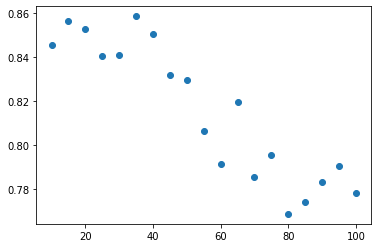

In [ ]:
if training:
  plot_maucs(test1["rfc"][2], list(range(10, 101, 5)))

In [ ]:
if training:
  test2 = best_svd_n(scaled_data,y_ob, y_cir, y_dia, 30, 41, 1)

In [ ]:
if training:
  print(f'Mejor MAUC: { test2["rfc"][0] }\nCon N features: {test2["rfc"][1]}')

Mejor MAUC: 0.8590792971761969
Con N features: 31


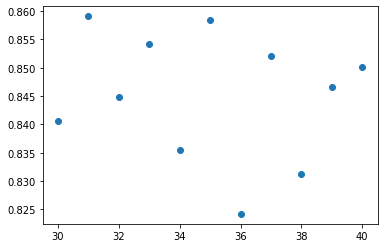

In [ ]:
if training:
  plot_maucs(test2["rfc"][2], list(range(30, 41, 1)))

In [ ]:
if training:
  test3 = best_svd_n(scaled_data,y_ob, y_cir, y_dia, 1, 11, 1, True)

In [ ]:
if training:
  print(f'Mejor MAUC: { test3["rfc"][0] }\nCon N features: {test3["rfc"][1]}')#0.8685879458559475

Mejor MAUC: 0.8685879458559475
Con N features: 5


In [ ]:
if training:
  test4 = best_svd_n(scaled_data,y_ob, y_cir, y_dia, 100, 101, 1, True)
  print(f'Mejor MAUC: { test4["rfc"][0] }\nCon N features: {test4["rfc"][1]}')

i: 100
Training RFC
rfc: 0.778302233323538

Mejor MAUC: 0.778302233323538
Con N features: 100


In [ ]:
if training:
  new_x = test4["rfc"][3]
  print(new_x.head(1))

   code_study_Chatelier_gut_obesity  ...  pc_col_99
0                                 0  ... -12.567312

[1 rows x 109 columns]


## Model Tunning

In [ ]:
def tune_model(X, y, min_n= 100, max_n = 501, step_n = 20, min_depth = 50, max_depth = 751, step_depth=50):
  parameters = {'n_estimators':list(range(min_n, max_n, step_n)), 'max_depth': list(range(min_depth, max_depth, step_depth))}
  rfc = RandomForestClassifier(random_state=0)
  clf = GridSearchCV(rfc, parameters)
  clf.fit(X, y)
  return clf

In [ ]:
if training:
  a = tune_model(new_x, y_ob)
  print(f'best score: {a.best_score_}\nparams: {a.best_params_}')

In [ ]:
if training:
  b = tune_model(new_x, y_ob, 140, 141, 1, 2, 76, 1)
  print(f'best score: {b.best_score_}\nparams: {b.best_params_}')

best score: 0.879058064516129
params: {'max_depth': 10, 'n_estimators': 140}


In [ ]:
if training:
  rfc_ob = tune_model(new_x, y_ob, 1, 100, 2, 3, 4, 1)
  print(f'best score: {rfc_ob.best_score_}\nparams: {rfc_ob.best_params_}')

best score: 0.8823225806451612
params: {'max_depth': 3, 'n_estimators': 1}


In [ ]:
if training:
  rfc_cir = tune_model(new_x, y_cir, 1, 100, 2, 3, 4, 1)
  print(f'best score: {rfc_cir.best_score_}\nparams: {rfc_cir.best_params_}')

best score: 0.8969032258064515
params: {'max_depth': 3, 'n_estimators': 35}


In [ ]:
if training:
  rfc_dia = tune_model(new_x, y_dia, 1, 100, 2, 3, 4, 2)
  print(f'best score: {rfc_dia.best_score_}\nparams: {rfc_dia.best_params_}')

best score: 0.7971354838709678
params: {'max_depth': 3, 'n_estimators': 5}


## Train model

In [ ]:
if training:
  X_train_ob, X_test_ob, y_train_ob, y_test_ob = train_test_split(new_x, y_ob, test_size=0.33, random_state=42)
  X_train_cir, X_test_cir, y_train_cir, y_test_cir = train_test_split(new_x, y_cir, test_size=0.33, random_state=42)
  X_train_dia, X_test_dia, y_train_dia, y_test_dia = train_test_split(new_x, y_dia, test_size=0.33, random_state=42)

In [ ]:
y_pred_train_rfc_ob, y_pred_test_rfc_ob, rfc_ob = predict_rfc(X_train_ob, y_train_ob, X_test_ob, y_test_ob)
y_pred_train_rfc_ob, y_pred_test_rfc_ob, rfc_cir = predict_rfc(X_train_cir, y_train_cir, X_test_cir, y_test_cir)
y_pred_train_rfc_ob, y_pred_test_rfc_ob, rfc_dia = predict_rfc(X_train_dia, y_train_dia, X_test_dia, y_test_dia)

# Export csv

In [ ]:
svd = TruncatedSVD(n_components=100, random_state=42)
pc_data = svd.fit_transform(scaled_data)
print(pc_data.shape)
X = pd.DataFrame(data = pc_data, columns = [f'pc_col_{i}' for i in range(pc_data.shape[1])])
X = pd.concat([cat_data, X], axis = 1)

(208, 100)


In [ ]:
X = svd_x(300, scaled_data, cat=True)

In [ ]:
X.shape

(208, 109)

In [ ]:
if not training:
  y_pred_ob = pd.Series(rfc_ob.predict(X))
  y_pred_cir = pd.Series(rfc_cir.predict(X))
  y_pred_dia = pd.Series(rfc_dia.predict(X))
  data = pd.concat([marker_data['Id'], y_pred_cir, y_pred_ob, y_pred_dia], axis = 1)
  data = data.rename(columns={0:'Cirrhosis', 1: 'Obesity', 2: 'Diabetes'})
  data.to_csv('result_rfc.csv', index=False)